In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import warnings

import pandas as pd
import ggplot as gg
import matplotlib as mpl
import networkx as nx
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [53]:
class PCA(object):
    def __init__(self, X):
        X = np.asarray(X)
        Xm = X.mean(axis=0)
        _, D, U = np.linalg.svd(X - Xm)
        D = (D ** 2) / (len(X) - 1)
        sorted_idx = np.argsort(D)[::-1]
        self.U = U[sorted_idx]
        self.D = D[sorted_idx]

    def project(self, X, m):
        X = np.asarray(X)
        X = X - X.mean(axis=0)
        Z = X @ self.U[:m].T
        return Z
    
    def denoise(self, X, m):
        X = np.asarray(X)
        Xm = X.mean(axis=0)
        Z = self.project(X - Xm, m)
        Xp = Z @ self.U[:m]
        Xp += Xm
        
        return Xp

In [3]:
from scipy.spatial.distance import pdist, squareform

def gammaidx(X, k):
    dists = squareform(pdist(X))
    dists = np.partition(dists, kth=k, axis=1)[:, :k+1]
    dists = np.sort(dists, axis=1)[:, 1:]
    y = dists.mean(axis=1)

    return y

In [7]:
def auc(y_true, y_val, plot=False):
    sorted_idx = np.argsort(y_val)[::-1]
    y_val = y_val[sorted_idx]
    y_true = y_true[sorted_idx]
    y_true = y_true == 1
    thresholds = np.copy(y_val)
    br_thresholds = np.broadcast_to(thresholds, (len(y_val), len(y_val))).T
    y_pred = y_val >= br_thresholds
    tp = (y_pred & y_true).sum(axis=1)
    fp = (y_pred & ~y_true).sum(axis=1)

    tpr = tp / len(y_true[y_true])
    fpr = fp / len(y_true[~y_true])
    
    if plot:
        plt.figure(figsize=(8, 8))
        plt.scatter(fpr, tpr, s=100, c='r')
        plt.plot(*np.r_['0,2', 0:1.1:.1, 0:1.1:.1], '--', alpha=0.7)
        plt.ylim(0, 1)
        plt.ylabel("True positive rate")
        plt.xlim(0, 1)
        plt.xlabel("False positive rate")
        plt.show()
    
    c = np.trapz(tpr, fpr)
    return c

In [103]:
from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform


def _get_neighbors(x, kdtree, k, epsilon):
    if epsilon:
        ret_val = kdtree.query_ball_point(x, r=epsilon)
    else:
        _, ret_val = kdtree.query(x, k=(k+1), n_jobs=-1)
    if isinstance(ret_val, int):
        ret_val = [ret_val]
    return np.array(ret_val)


def lle(X, m, tol, n_rule, k=None, epsilon=None, return_kdtree=False):
    X = X.copy()
    N, D = X.shape
    kdtree = None
    dists = None
    
    if m > D:
        raise ValueError("m must be less than the dimensionality of X's vectors")
    if n_rule == 'knn':
        try:
            k = int(k)
            assert k >= 0
        except:
            raise ValueError("k must be a positive integer for the 'knn' rule")
        epsilon = None
    elif n_rule == 'eps-ball':
        try:
            epsilon = float(epsilon)
            assert epsilon >= 0
        except:
            raise ValueError("epsilon must be a positive float for the 'eps-ball' rule")
        k = 1
    else:
        raise ValueError("n_rule must be one of ('knn', 'eps_ball')")
    if tol <= 0:
        raise ValueError("tol must be greater than 0")
    
    W = np.zeros([N, N])  # matrix for storing reconstruction weights
    M = np.zeros([N, N])  # matrix M of which eigenvectors are computed
    E = np.zeros([N, 2])  # eigenvectors of M forming the embedding
    ones_vec = np.ones(D)
    X = X - np.mean(X, axis=0)
    kdtree = cKDTree(X, leafsize=k)
    
    # Iterate over all data points to find their associated reconstruction weights
    for i in range(N):
        # 1. find nearest neighbors of data[i]
        x_i = X[i]
        #    k+1 -> the query might return the x_i's index too,
        indexes = _get_neighbors(x_i, kdtree, k, epsilon)
        #    so we remove it from the indexes if it's there,
        indexes = indexes[indexes != i]
        neighbors_nr = len(indexes)
        if neighbors_nr == 0:
            raise ValueError(f"Graph is not connected for k: {k}; epsilon: {epsilon}")
        # 2. compute local covariance
        local_c = x_i - X[indexes]
        local_c = np.dot(local_c, local_c.T)
        #    (with diagonal regularization),
        local_c += tol * np.trace(local_c) * np.eye(neighbors_nr)
        # 3. compute reconstruction weights
        w_i = np.linalg.solve(local_c, np.ones(neighbors_nr))
        #    and store them in the row of the matrix W
        W[i, indexes] = w_i/np.sum(w_i)
    # 4. Compute the matrix M from W
    M = np.eye(N) - W
    M = np.dot(M.T, M)
    #    and compute the desired eigenvectors E of M-
    eig_vals, E = np.linalg.eig(M)

    # Array of sums over each eigenvector
    sumflat_eig_vecs = E.sum(axis=0)**2
    
    # Remove the vector with equal components not summing up to zero, where
    # eigenvectors are still unit-vectors. So we find it by using this filter:
    mask = sumflat_eig_vecs < 1
    eig_vals = eig_vals[mask]
    E = E[:, mask]
    
    # Find indices of the smallest d eigenvectors (smallest wrt. eig_vals)
    sorted_idx = np.argsort(eig_vals)[:m]

    # Result: The smallest d eigenvectors
    if return_kdtree:
        return E[:, sorted_idx], kdtree
    return E[:, sorted_idx]


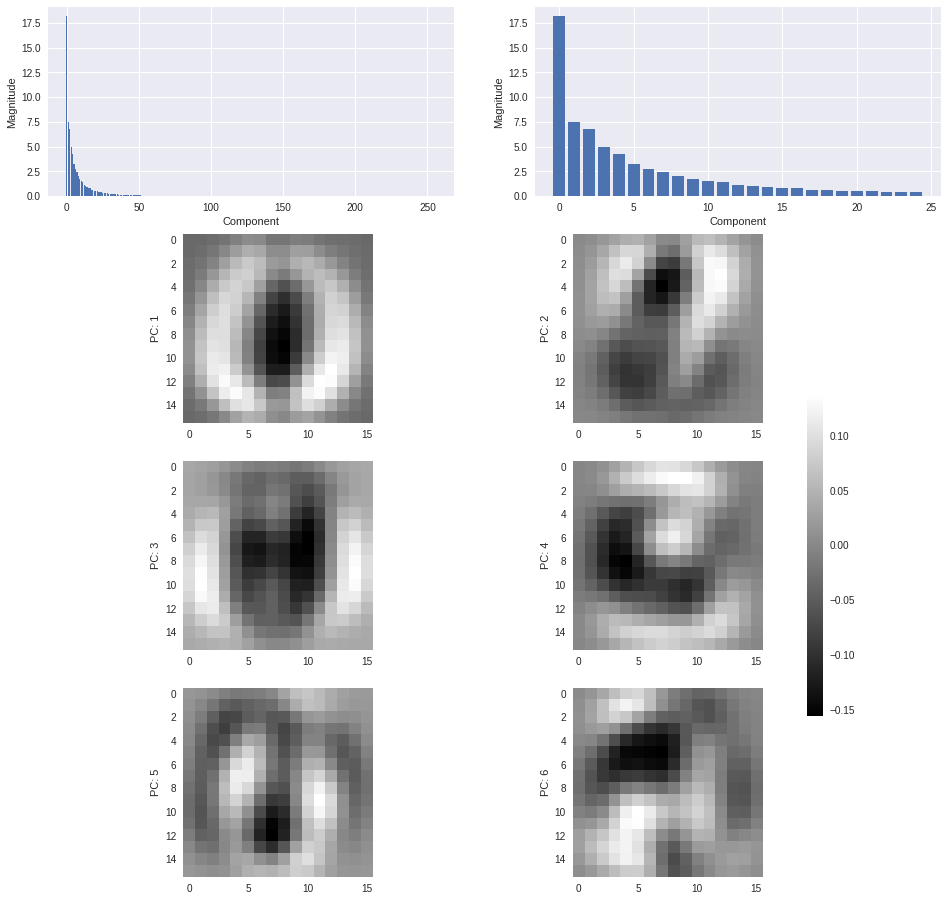

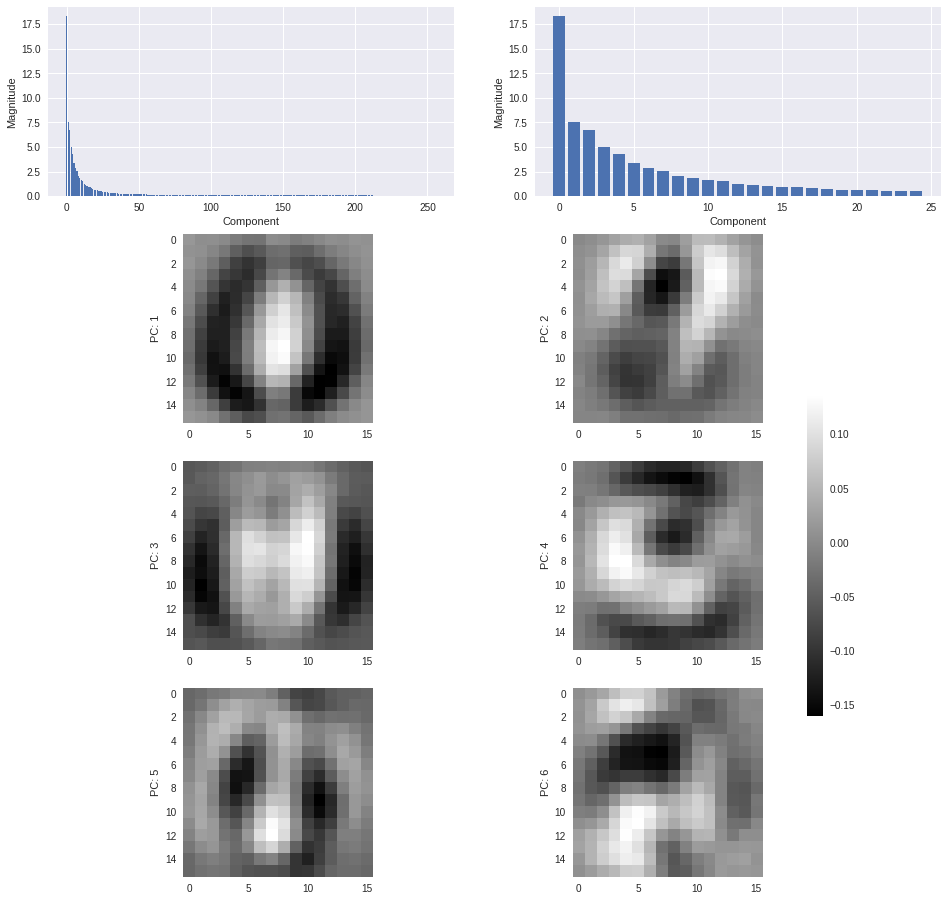

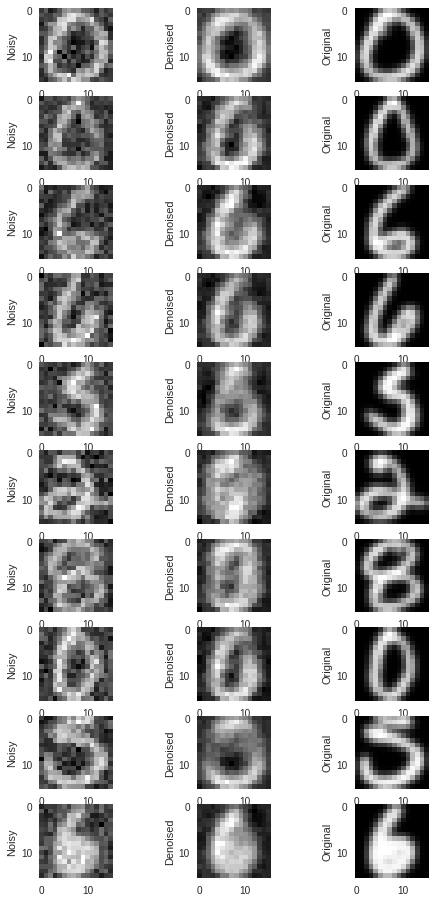

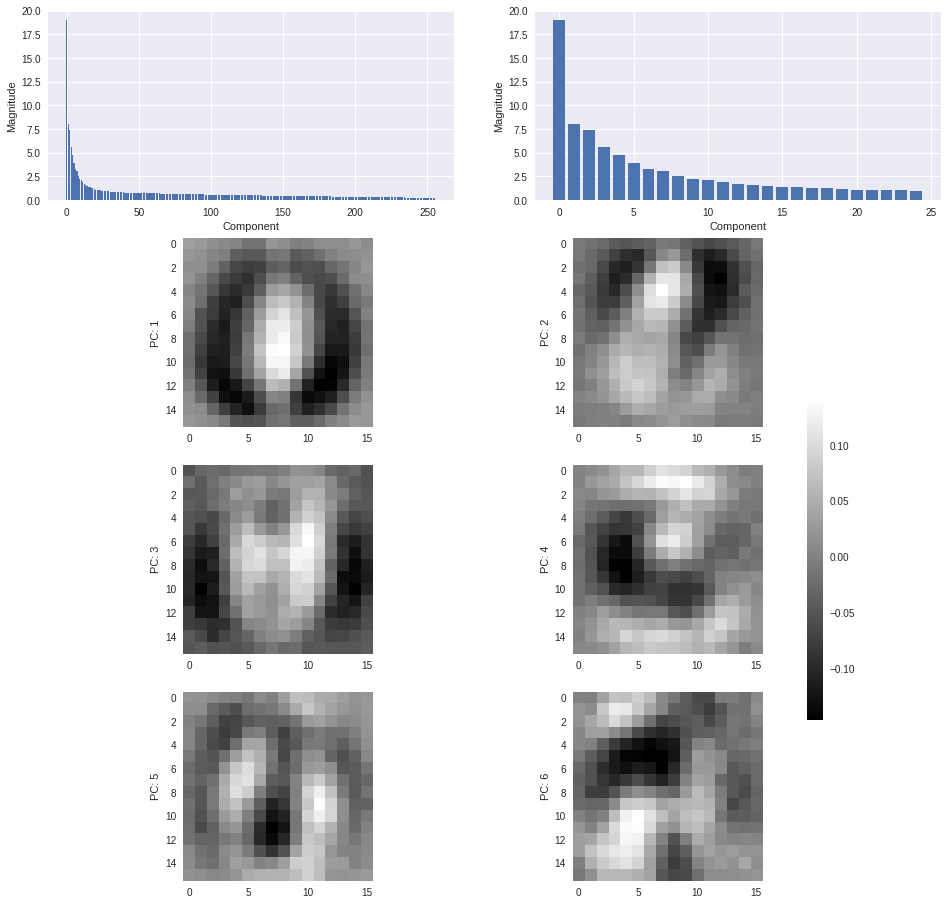

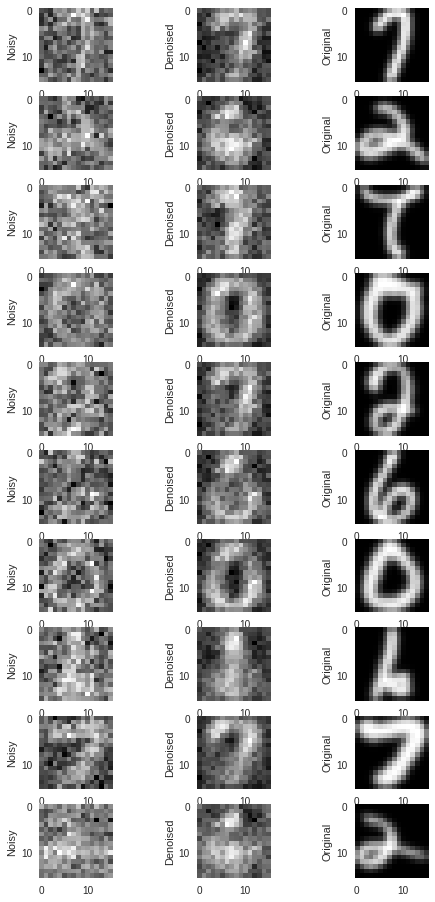

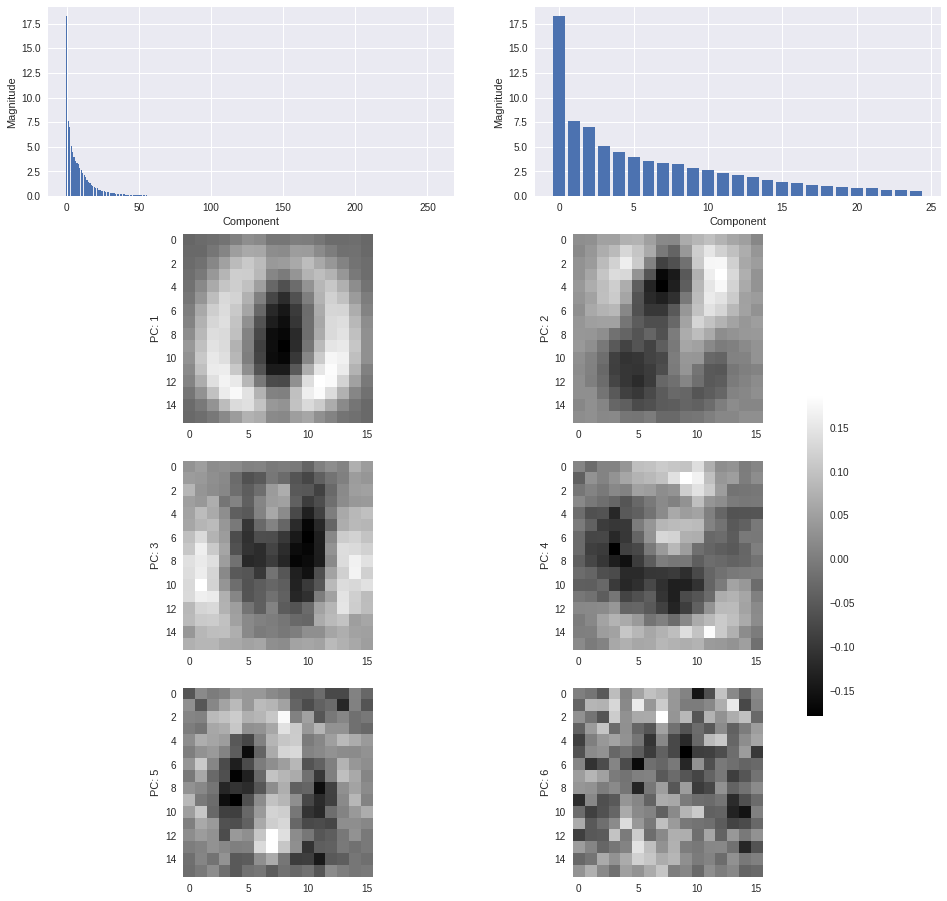

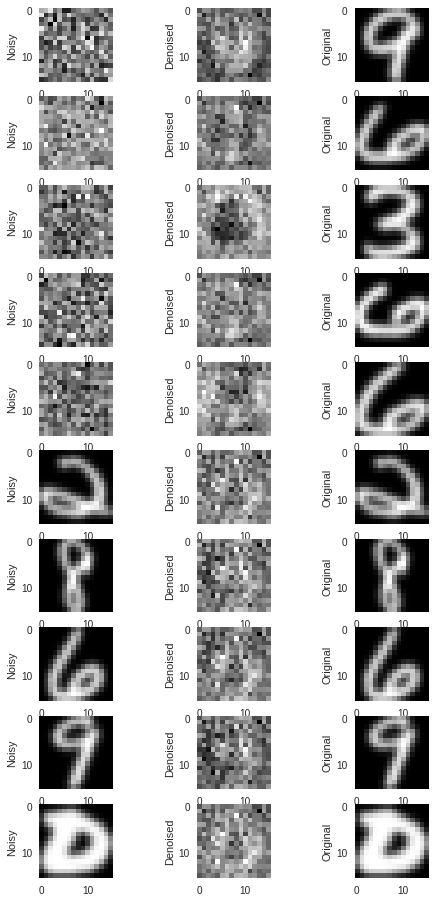

In [93]:
# noinspection PyPep8Naming
def _denoise(X, U, m):
    X = np.asarray(X)
    Xm = X.mean(axis=0)
    X = X - Xm
    Z = X @ U[:m].T
    Xp = Z @ U[:m]
    Xp += Xm
    return Xp


# noinspection PyUnresolvedReferences,PyPep8Naming
def _plot_denoising(orig_X, noisy_X, U, m, n_samples=10, r_idx=None):
    cmap = plt.cm.gray
    N, M = orig_X.shape
    imD = int(M**0.5)
    imD = imD, imD
    if r_idx is None:
        r_idx = np.array([])
    indexes = set(np.arange(len(orig_X))) - set(r_idx)
    indexes = np.array(list(sorted(indexes)))
    r_idx = np.hstack((r_idx,
                       np.random.choice(indexes,
                                        size=n_samples-len(r_idx),
                                        replace=False)))
    r_idx = r_idx.astype(int)
    orig_X = orig_X[r_idx, :]
    noisy_X = noisy_X[r_idx, :]
    denoised_X = _denoise(noisy_X, U, m)
    noisy_X = noisy_X.reshape(len(r_idx), *imD)
    denoised_X = denoised_X.reshape(len(r_idx), *imD)
    orig_X = orig_X.reshape(len(r_idx), *imD)

    # noinspection PyTypeChecker
    _, axes = plt.subplots(n_samples, 3, figsize=(8, 16))
    for noisy_x, denoised_x, orig_x, (ax1, ax2, ax3) in\
            zip(noisy_X, denoised_X, orig_X, axes):
        ax1.imshow(noisy_x, cmap=cmap, interpolation='none', aspect='equal')
        ax1.set_ylabel(f"Noisy")
        ax1.grid()
        ax2.imshow(denoised_x, cmap=cmap, interpolation='none', aspect='equal')
        ax2.set_ylabel(f"Denoised")
        ax2.grid()
        ax3.imshow(orig_x, cmap=cmap, interpolation='none', aspect='equal')
        ax3.set_ylabel(f"Original")
        ax3.grid()


# noinspection PyPep8Naming
def _apply_pca(X):
    pca = PCA(X)
    return pca.U, pca.D


# noinspection PyPep8Naming
def _plot_pca(U, D):
    # noinspection PyUnresolvedReferences
    cmap = plt.cm.gray
    M = U.shape[1]
    imD = int(M**0.5)
    imD = imD, imD
    # noinspection PyTypeChecker
    fig, axes = plt.subplots(4, 2, figsize=(16, 16))
    ax1, ax2, *axes = axes.flatten()
    ax1.bar(range(len(D)), D)
    ax1.set_ylabel('Magnitude')
    #ax1.set_yscale('log')
    ax1.set_xlabel('Component')
    ax2.bar(np.arange(len(D))[:25], D[:25])
    ax2.set_ylabel('Magnitude')
    ax2.set_xlabel('Component')
    im = None
    for i, (u, ax) in enumerate(zip(U, axes), 1):
        u = u.reshape(imD)
        im = ax.imshow(u, cmap=cmap, interpolation='none', aspect='equal')
        ax.set_ylabel(f"PC: {i}")
        ax.grid()
    if im is not None:
        fig.colorbar(im, ax=axes, shrink=0.5)
    plt.show()


# noinspection PyPep8Naming
def usps():
    #   1. Load the usps data set.
    data = loadmat('./usps.mat')
    patterns = data['data_patterns'].T
    N, M = patterns.shape

    #   2. Analysis of PCA:
    #     (a) Calculate the PCA of this data.
    #     (b) Visualize (a) all principal values, (b) the largest 25 principal
    #         values (both as a bar plot, see bar) and (c) the first 5
    #         principal directions (as images, see imshow).
    U, D = _apply_pca(patterns)
    _plot_pca(U, D)
    #   3. Consider three noise scenarios (use numpy.random.randn):
    #     For each of the scenarios
    #     (a) Calculate the PCA of this data and redo the plots of principal
    #         values. Explain the differences to the original spectrum.
    #     (b) Denoise the images by reconstruction from projections on the m
    #         largest principal components
    #
    #     • low gaussian noise: add Gaussian noise to the images. Select an
    #       appropriate variance such that the resulting images are moderately
    #       noisy.
    l_sigma = 0.3
    lgn_X = patterns + np.random.randn(N, M)*l_sigma
    U, D = _apply_pca(lgn_X)
    _plot_pca(U, D)
    _plot_denoising(patterns, lgn_X, U, 5)
    #     • high gaussian noise: add Gaussian noise to the images. Select an
    #       appropriate variance such that the resulting images are very noisy.
    h_sigma = 0.7
    hgn_X = patterns + np.random.randn(N, M)*h_sigma
    U, D = _apply_pca(hgn_X)
    _plot_pca(U, D)
    _plot_denoising(patterns, hgn_X, U, 5)
    #     • outliers: add Gaussian noise to only five images. Select an
    #       appropriate variance such that those five images are extremely
    #       noisy and that the noise is reflected in the spectrum.
    o_sigma = 5
    rand_vec = np.zeros_like(patterns)
    rand_vec[:5] += np.random.randn(5, M)*o_sigma
    out_X = patterns + rand_vec
    U, D = _apply_pca(out_X)
    _plot_pca(U, D)
    _plot_denoising(patterns, out_X, U, 5, r_idx=np.arange(5))
    #     (c) For 10 examples of your choice (including the noisy ones in
    #         the outlier setting), plot the original image, the noisy image
    #         and its denoised reconstruction (using imshow)
usps()

In [99]:
from tqdm import tqdm_notebook as tqdmn, tqdm
data = np.load('./banana.npz')
labels = data['label'].T
labels = labels == 1
data = data['data'].T
data = np.r_['1,2', data, labels]
labels = labels.flatten()
inliers = data[labels]
outliers = data[~labels]

outlier_rates = [0.01, 0.05, 0.1, 0.25]
rates_nr = len(outlier_rates)
repetitions = 100
results = pd.DataFrame(np.zeros((repetitions*3*rates_nr, 3)),
                       columns=['auc_score', 'method', 'out_rate'])
i = 0
for out_rate in tqdmn(outlier_rates, total=rates_nr):
    for _ in tqdmn(range(0, repetitions*3, 3),
                   total=repetitions,
                   leave=False):
        out_nr = int(round(len(inliers)*out_rate))
        out_idx = np.random.randint(len(outliers), size=out_nr)
        X = np.r_['0,2', inliers, outliers[out_idx]]
        y_true = X[:, -1]
        X = X[:, :-1]
        gamma3 = gammaidx(X, k=3)
        gamma5 = gammaidx(X, k=5)
        d2mean = np.linalg.norm(X - X.mean(axis=0), axis=1)
        auc_gamma3 = auc(y_true, gamma3)
        auc_gamma5 = auc(y_true, gamma5)
        auc_d2mean = auc(y_true, d2mean)
        results.iloc[i] = [auc_gamma3, 'g3', out_rate]
        results.iloc[i+1] = [auc_gamma5, 'g5', out_rate]
        results.iloc[i+2] = [auc_d2mean, 'd2m', out_rate]
        i += 3


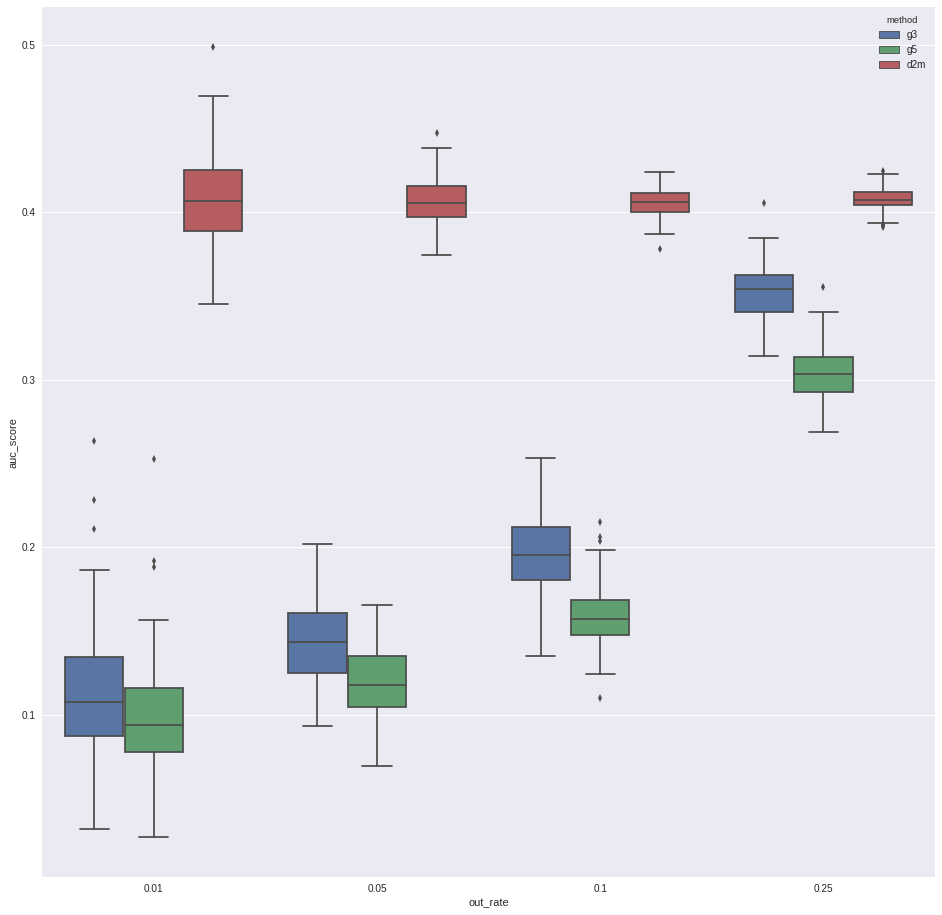

In [100]:
plt.figure(figsize=(16, 16))
sns.boxplot(x='out_rate', y='auc_score', hue='method', data=results)

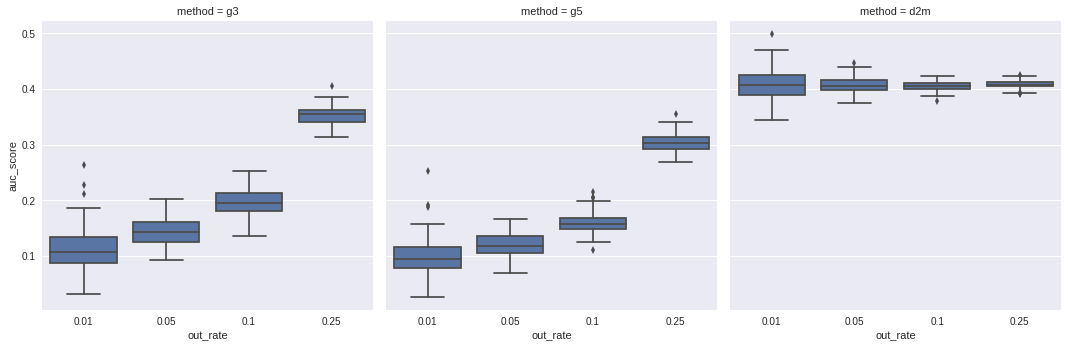

In [102]:
g = sns.FacetGrid(results, col='method', size=5, aspect=1)
g.map(sns.boxplot, 'out_rate', 'auc_score')

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fishbowl = np.load('fishbowl_dense.npz')['X'].T
fb_ref = fishbowl[:, 2]

swissroll = np.load('swissroll_data.npz')
sr_ref = swissroll['z'].T[:, 1]
swissroll = swissroll['x_noisefree'].T

flatroll = np.load('flatroll_data.npz')
fr_ref = flatroll['true_embedding']
flatroll = flatroll['Xflat'].T

fb_lleX = lle(fishbowl, 2, 1e-3, 'knn', k=50)
sr_lleX = lle(swissroll, 2, 1e-3, 'knn', k=40)
fr_lleX = lle(flatroll, 1, 1e-3, 'knn', k=20)

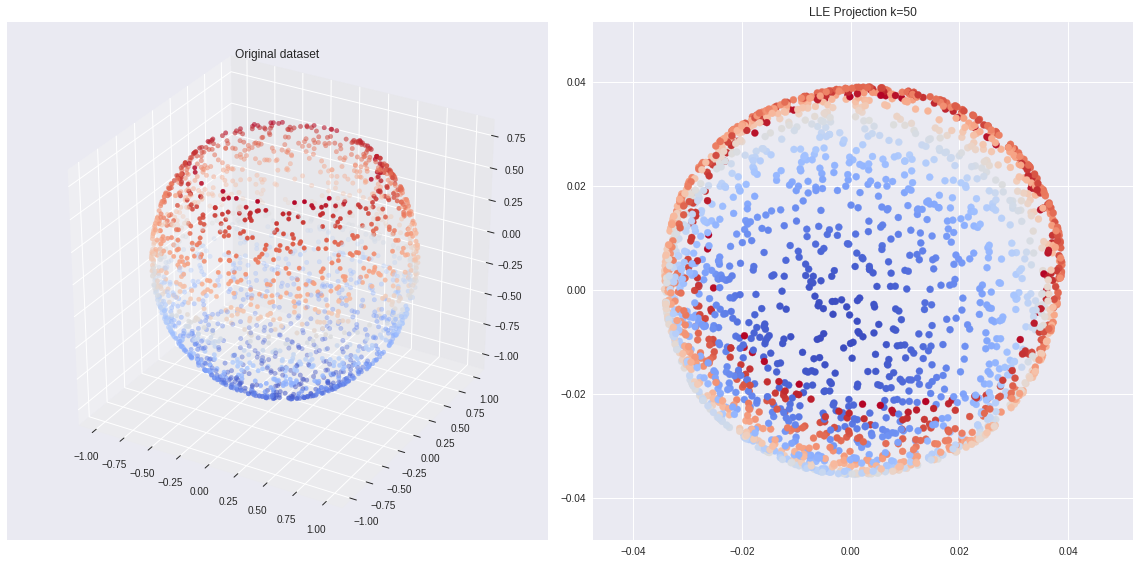

In [11]:
cmap = plt.cm.coolwarm
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*fishbowl.T, c=fb_ref, cmap=cmap)
ax2 = fig.add_subplot(122)
ax2.scatter(*fb_lleX.T, c=fb_ref, cmap=cmap)

ax1.set_title("Original dataset")
ax2.set_title("LLE Projection k=50")
plt.tight_layout()

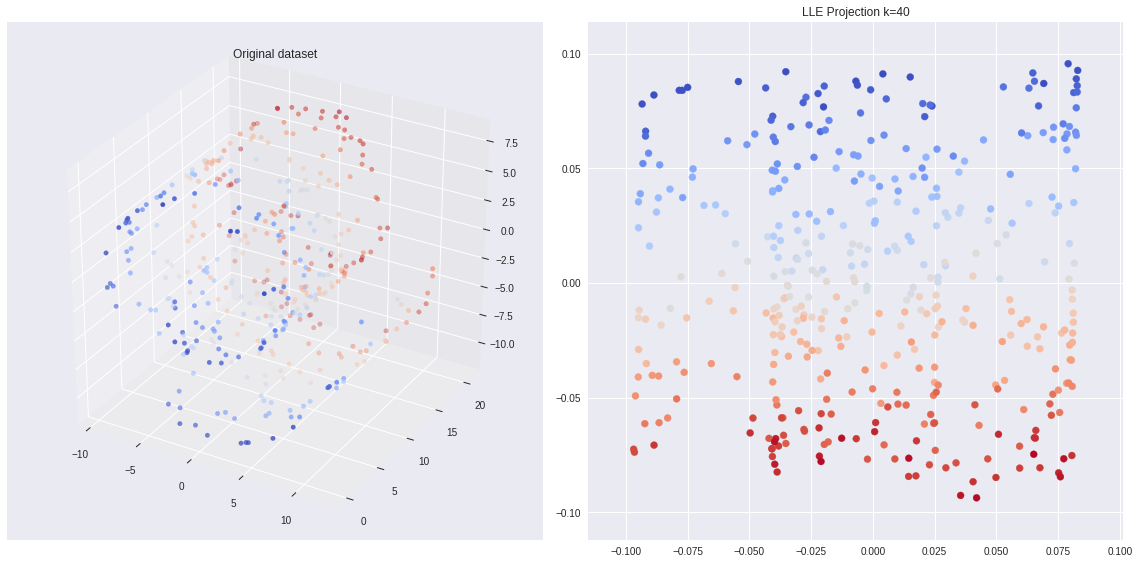

In [12]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*swissroll.T, c=sr_ref, cmap=cmap)
ax2 = fig.add_subplot(122)
ax2.scatter(*sr_lleX.T, c=sr_ref, cmap=cmap)

ax1.set_title("Original dataset")
ax2.set_title("LLE Projection k=40")
plt.tight_layout()

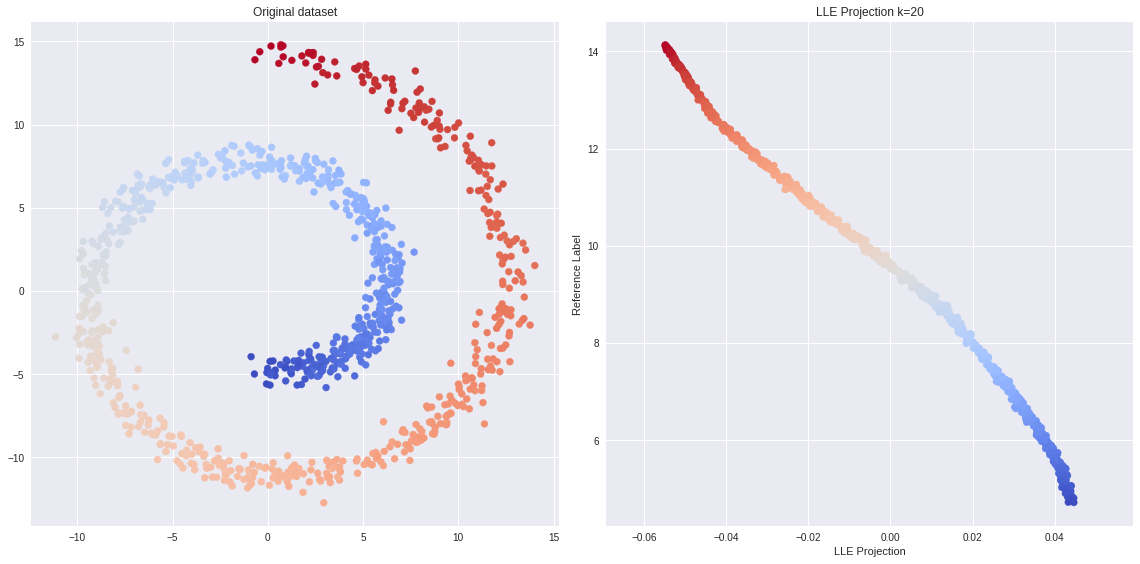

In [13]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(*flatroll.T, c=fr_ref, cmap=cmap)
ax2 = fig.add_subplot(122)
ax2.scatter(fr_lleX, fr_ref, c=fr_ref, cmap=cmap)

ax1.set_title("Original dataset")
ax2.set_title("LLE Projection k=20")
ax2.set_ylabel("Reference Label")
ax2.set_xlabel("LLE Projection")
plt.tight_layout()

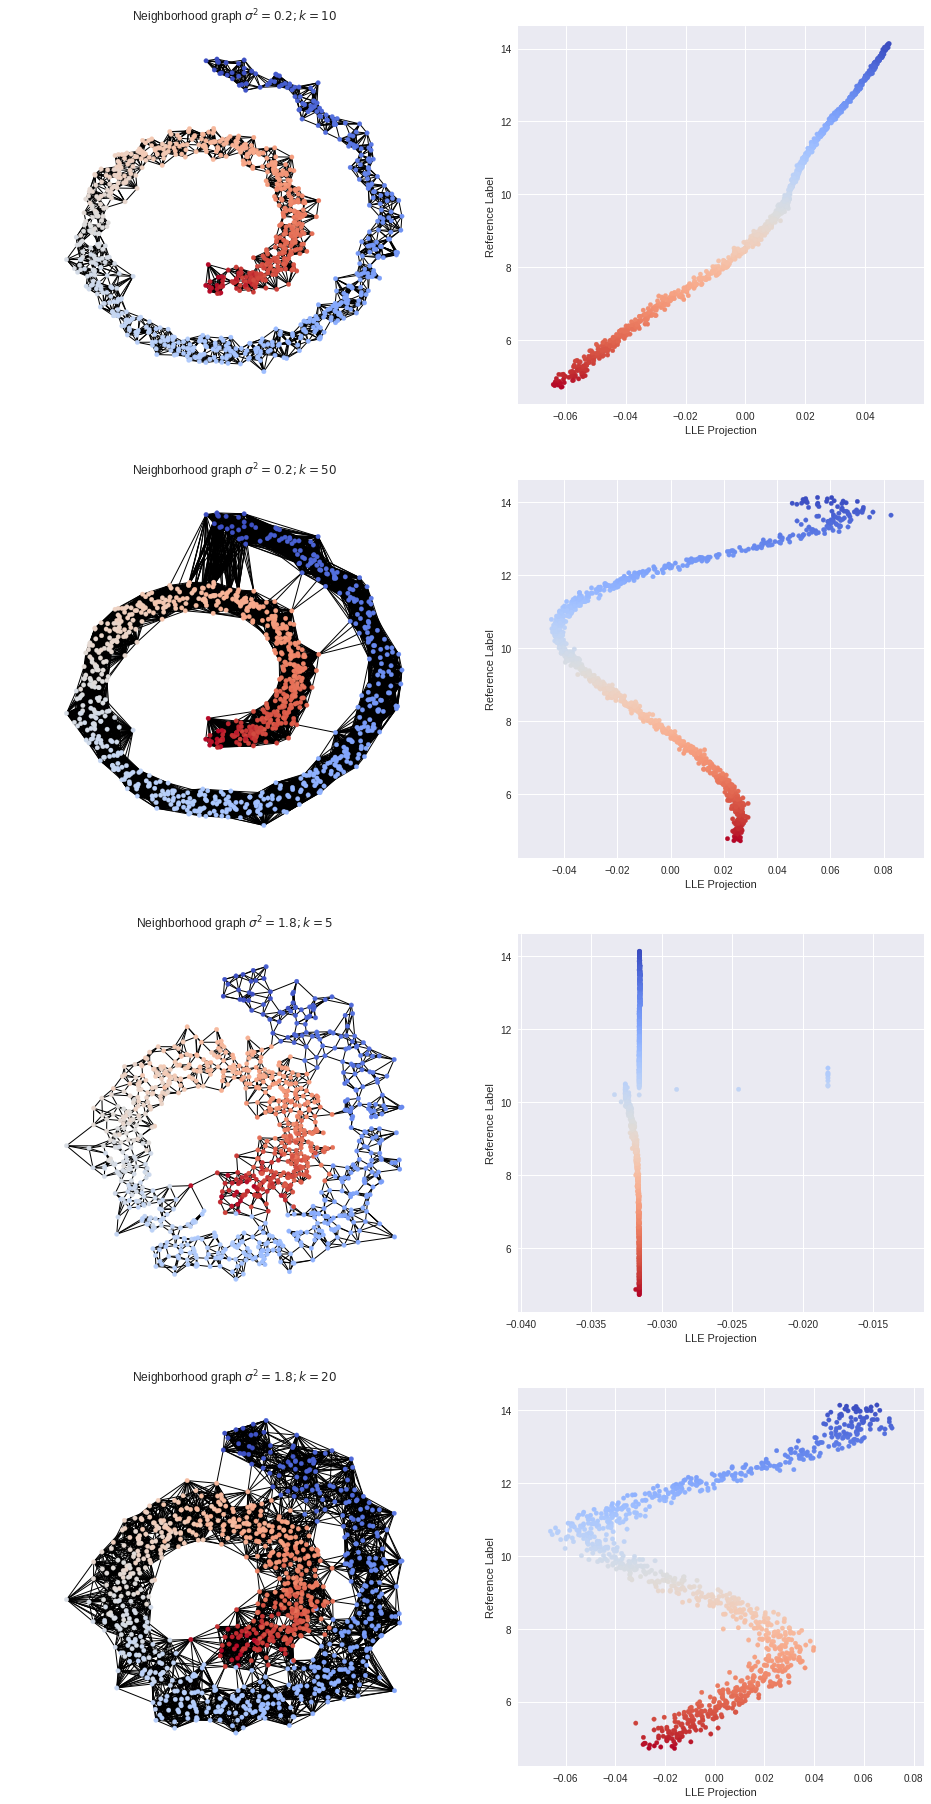

In [3]:
from sklearn.manifold import LocallyLinearEmbedding

flatroll = np.load('flatroll_data.npz')
fr_ref = flatroll['true_embedding']
flatroll = flatroll['Xflat'].T

fr_noisy1 = flatroll + np.random.randn(*flatroll.shape)*np.sqrt(0.2)
fr_noisy2 = flatroll + np.random.randn(*flatroll.shape)*np.sqrt(1.8)

def draw_lle(data, data_ref, k, ax1, ax2, tol, sigma_sq):
    cmap = plt.cm.coolwarm_r
    lle = LocallyLinearEmbedding(n_neighbors=k, n_components=1, tol=tol)
    data_lle = lle.fit_transform(data)
    neighbors = lle.nbrs_.kneighbors(return_distance=False)
#     data_lle, kdtree = lle(data, 1, tol, 'knn', k=k, return_kdtree=True)
#     _, neighbors = kdtree.query(data, k=k)
    neighbors = set(frozenset((i, n))
                    for i, l in enumerate(neighbors)
                    for n in l if i != n)
    G = nx.Graph()
    G.add_nodes_from(range(len(data)))
    G.add_edges_from(neighbors)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=(mpl.cbook.MatplotlibDeprecationWarning, UserWarning))
        nx.draw(G, data, ax=ax1, node_size=20, node_color=data_ref, cmap=cmap)
    ax2.scatter(data_lle, data_ref, s=20, c=data_ref, cmap=cmap)
    ax1.set_title(f"Neighborhood graph $\sigma^2={sigma_sq}; k={k}$")
    ax2.set_xlabel("LLE Projection")
    ax2.set_ylabel("Reference Label")

D = [fr_noisy1, fr_noisy1, fr_noisy2, fr_noisy2]
K = [10, 50, 5, 20]
_, axes = plt.subplots(4, 2, figsize=(16, 32))
TOL = [0.001, 0.001, 1, 1]
V = [0.2, 0.2, 1.8, 1.8]

for data, k, (ax1, ax2), tol, v in zip(D, K, axes, TOL, V):
    draw_lle(data, fr_ref, k, ax1, ax2, tol, v)

plt.show()